### Vesuvius Challenge - Ink Detection

In this challenge, which I personally find fascinating, the effort is to resurrect an ancient library buried under the ashes of the Vesuvius volcano some 2000 years ago. The library was located in a Roman villa, near Pompeii, and contained thousand of scrolls. They were discovered a few hundred years ago and this has led to the quest to be able to read them using today's technology. 

The scrolls were carbonized and remain unreadable to today, and it will require special techniques such as 3d Xrays scans to read the scrolls by detecting the ink, hence the challenge name 'Vesuvius Ink Detection'.

### Objective 


The result of the segmentation should help in revealing the content. 

**Imagine the secrets of Roman and Greek philosophy, science, literature, mathematics, poetry, and politics, which are locked away in these lumps of ash, waiting to be read!**

A team of scientists led by Dr. Brent Seales have used X-Ray tomography and CV to read scrolls found in other places, as old as Roman scrolls. However in these scrolls carbon was used affording no X-ray against the carbon-based papyrus. 
Under infrared light, using particle accelerator, some detached parts of the papyrus are readable, which led to the use of machine learning to identify letters in ink with known samples. To desribe it is to use machine learning for the invisible link with ground truth data. 
https://scrollprize.org/img/landing/anim2b_4.webm
The input to the accelerator were two scrolls and several fragments with 4-6 um resolution and 16 bit density of data per voxel, and they believe the machine learning modeling will be able to pick the characters from the subtle areas where the ink is detectable. 

In early 2023 this team at University of Kentucky has achieved a breakthrough in being able to detect the ink with Xray technology thus being able in the future to uncover the characters written in the scrolls. 

The challenge here is to be able to understand the problem and contribute in a modest way to expedite the reading of the scrolls. 

**After 275 years, the problem with the ancient library comes to a software. **


### **Exploratory Phase**

In [ ]:
!ls /content/drive/MyDrive/A_Vesuvius/train/1
!ls /content/drive/MyDrive/A_Vesuvius/train/2/surface_volume | wc

inklabels.png  inklabels_rle.csv  ir.png  mask.png  surface_volume
     66      66     459


In [ ]:
import numpy as np
import math
import cv2 as cv 
import matplotlib.pyplot as plt 
from IPython.display import HTML, display 
from celluloid import Camera
from tqdm.notebook import tqdm 
import seaborn as sns 

In [ ]:
n_scan_layers = 65 
PREFIX = f'/content/drive/MyDrive/A_Vesuvius/' 

def load_surface_volume(path, folder): 
  filepath = f'{PREFIX}{path}/{folder}/surface_volume/'
  file_format = '{:02d}.tif'
  surface_volume = []
  for i in tqdm(range(n_scan_layers)):
    file = f'{filepath}{file_format.format(i)}'
    img_ = cv.imread(file, cv.IMREAD_ANYDEPTH)
    surface_volume.append(img_.astype(float))
  return surface_volume

def surface_volume(path, folder): 
  surface_volume = load_surface_volume(path, folder)
  fig, ax = plt.subplots()
  camera = Camera(fig)
  for i in range(n_scan_layers):
    ax.axis('off') 
    ax.text(0.5, 1.0, f'layer {i+1}/{n_scan_layers}', 
                transform=ax.transAxes, horizontalalignment='center')
    ax.imshow(surface_volume[0], cmap='gray')
    camera.snap()
    del surface_volume[0]
    gc.collect()
  plt.close(fig)
  animation = camera.animate()
  video_display = '<style>video {margin: 0px; padding=0px;}</style>'
  display(HTML(video_display + animation.to_html5_video()))

  del camera
  del animation 
  gc.collect() 

Content of papyrus visualized from a series of scans of the dataset

In [ ]:
surface_volume('train', '1')

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
surface_volume('train', '2')

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
surface_volume('train', '3') 

  0%|          | 0/5 [00:00<?, ?it/s]

We look into the shape of the images, 5 scrolls; 2 for test set and 3 for train set - expected that scrolls will have different sizes 
- Train 2 is almost double in size and number of pixels varies as well
- Images in Train are in format landscape oriented 
- Images in Test and in format portrait oriented 

In [ ]:
import pandas as pd 
PREFIX = f'/content/drive/MyDrive/A_Vesuvius/' 
def scroll_dimensions(path, folder):
  filename = f'{PREFIX}{path}/{folder}/mask.png'
  img_ = cv.imread(filename, cv.IMREAD_ANYDEPTH)
  return img_.shape
scroll_dimensions('train', '1'), scroll_dimensions('train', '2'), scroll_dimensions('train', '3'), \
scroll_dimensions('test', 'a'), scroll_dimensions('test', 'b')

def scrolls_dimensions():
  scroll_samples, scroll_shapes, number_of_pixels = [], [], []
  scrolls = {'train': ['1', '2', '3'], 'test': ['a', 'b']}
  for set_ in scrolls: 
    for folder in scrolls[set_]:
      scroll_samples.append(f'{set_} {folder}')
      shape = scroll_dimensions(set_, folder)
      scroll_shapes.append(shape)
      number_of_pixels.append(shape[0]*shape[1])
  dataframe_for_stats = pd.DataFrame([scroll_shapes, number_of_pixels], columns=scroll_samples)
  return dataframe_for_stats 
dataframe_for_stats = scrolls_dimensions()
dataframe_for_stats.T

,0,1
train 1,"(8181, 6330)",51785730
train 2,"(14830, 9506)",140973980
train 3,"(7606, 5249)",39923894
test a,"(2727, 6330)",17261910
test b,"(5454, 6330)",34523820


Inklabels and Masks 
- Train set has 'ir' files that include 'inklabels', which is very important for the problem we are trying to solve ~ the information to predict 
- Test set doesn't have 'ir' files
- Masks are binary images that delimit the scroll from the backgound 

Insights 
- The Masks define the boundaries between the papyrus scroll and the background 
- The Infrared files show the ink on the paper we use to create the label 
- The label images are binary images where the pixels indicate the location of the ink 

The aim here is the Segmentation identifying the location of the ink on the paper, with each pixel having the value of 0 or 1.  

Calculate the proportion of paper covered by ink for each papyrus using masks and ink labels provided in the dataset. 

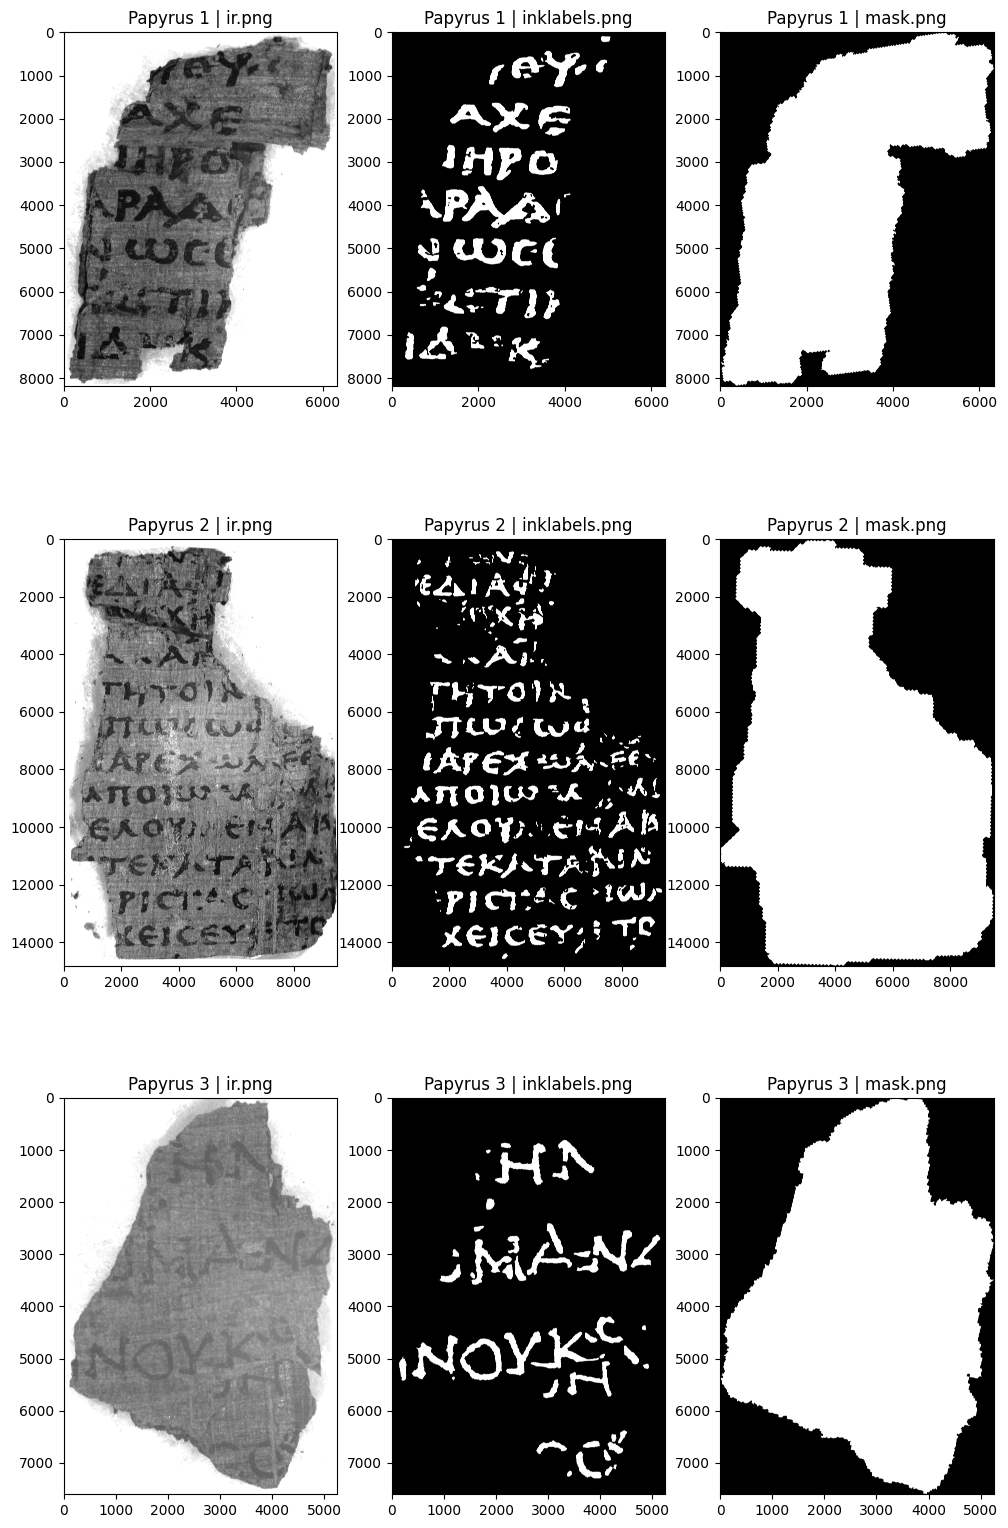

In [ ]:
""" train set """ 
files = ['ir.png', 'inklabels.png', 'mask.png']
plt.figure(figsize=(12, 20))
r_ct = 1
for i in range(1, 4):
  folder = f'/content/drive/MyDrive/A_Vesuvius/train/'
  for file in files:
    filepath=f'{folder}{i}/{file}' 
    img_ = cv.imread(filepath, cv.IMREAD_ANYDEPTH)
    plt.subplot(3, 3, r_ct)
    plt.imshow(img_.astype(float), cmap='gray') 
    plt.title(f'Papyrus {i} | {file }')
    r_ct +=1 
plt.show()

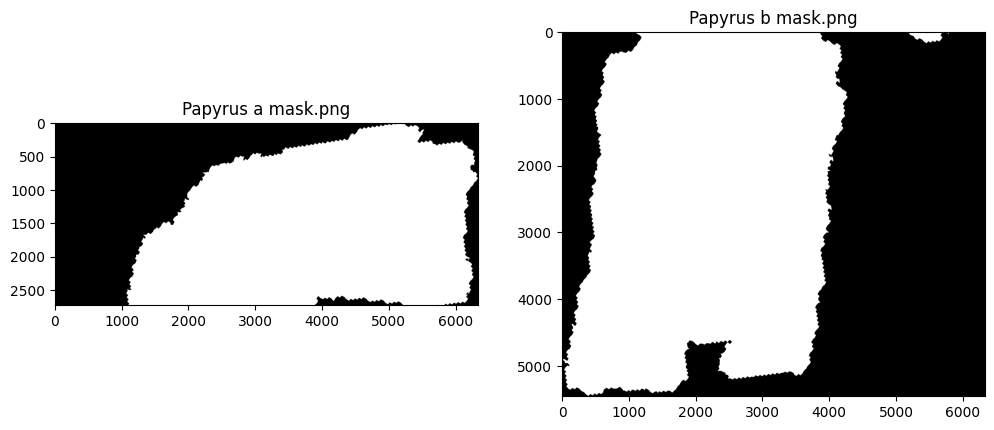

In [ ]:
plt.figure(figsize=(12, 10))
for idx, val in enumerate(['a', 'b']):
  folder = f'/content/drive/MyDrive/A_Vesuvius/test/'
  filepath= f'{folder}{val}/mask.png'
  img_ = cv.imread(filepath, cv.IMREAD_ANYDEPTH)
  plt.subplot(1, 2, idx+1)
  plt.imshow(img_.astype(float), cmap='gray') 
  plt.title(f'Papyrus {val} mask.png')
plt.show()

### Data processing 

In [ ]:
import glob
import PIL, PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
PREFIX = f'/content/drive/MyDrive/A_Vesuvius/' 
import numpy as np
import pandas as pd
import torch
import torch.utils.data as data 

In [ ]:
def resize(image): 
  width, height = image.size
  aspect_ratio = width/height 
  shared_height = 8000
  new_width = int(shared_height * aspect_ratio)
  new_size = (new_width, shared_height)
  image = image.resize(new_size)
  return image

In [ ]:
z_slices, labels, masks = [[] for _ in range(3)], [[] for _ in range(3)], [[] for _ in range(3)]
for i in [1, 2, 3]:
  z_slices[i-1] += sorted(glob.glob(
      f'{PREFIX}/train/{i}/surface_volume/*.tif'))[1:4]
  img_l = Image.open(f'{PREFIX}train/{i}/inklabels.png')
  img_l = resize(img_l)
  labels[i -1]= torch.from_numpy(np.array(img_l)).gt(0).float()
  img_m = Image.open(f'{PREFIX}train/{i}/mask.png').convert('1')
  img_m = resize(img_m)
  masks[i -1] = np.array(img_m)

z_slices
labels, 
len(z_slices) 

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


3

In [ ]:
np.array(Image.open('/content/drive/MyDrive/A_Vesuvius/train/2/surface_volume/09.tif'), 
         dtype=np.float32)/65536.0 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
image_tensors__ = [np.array(Image.open(img_name), dtype=np.float32)/65536.0  
  for img_name in z_slices[0] ] 

In [ ]:
image_stack = torch.stack([torch.from_numpy(image_tensor) 
for image_tensor in image_tensors__]) 
z_dimension = image_stack.shape[0] 
image_stack.shape

torch.Size([3, 8181, 6330])

In [ ]:
image_tensors__, image_stack = [], []

In [ ]:
""" 
torch.Size([10, 8000, 6189])
torch.Size([10, 8000, 5127])
torch.Size([10, 8000, 5520])
"""
arr_1 = torch.ones((10, 30, 50))
arr_2 = torch.zeros((10, 30, 50))
arr_ = torch.stack([arr_1, arr_1], dim=0)
arr__ = torch.stack([arr_2, arr_2], dim=0)
arr_stack = [arr_, arr__]
arr_volume = torch.cat([arr_stack[0], arr_stack[1]], axis=1)
arr_.shape, arr__.shape, arr_volume.shape 

(torch.Size([2, 10, 30, 50]),
 torch.Size([2, 10, 30, 50]),
 torch.Size([2, 20, 30, 50]))

In [ ]:
images = [[] for _ in range(3)]
for i in range(3):
  images_ = []
  for index_, filename in tqdm(enumerate(z_slices[i])):
    img_ = Image.open(filename)
    img_ = resize(img_)
    z_slice = np.array(img_, dtype='float32')/65535.0
    images_.append(z_slice)
  images[i] = torch.stack([torch.from_numpy(image) for image in images_], dim=0)

3it [00:05,  1.97s/it]
3it [00:11,  3.89s/it]
3it [00:05,  1.89s/it]


In [ ]:
images[0].shape, images[1].shape, images[2].shape,

(torch.Size([3, 8000, 6189]),
 torch.Size([3, 8000, 5127]),
 torch.Size([3, 8000, 5520]))

In [ ]:
labels[0].shape, labels[1].shape, labels[2].shape,

(torch.Size([8000, 6189]), torch.Size([8000, 5127]), torch.Size([8000, 5520]))

In [ ]:
masks[0].shape, masks[1].shape, masks[2].shape,

((8000, 6189), (8000, 5127), (8000, 5520))

In [ ]:
images_tensors = torch.cat([image for image in images], axis=-1)
labels_tensors = torch.cat([label for label in labels], axis=1)
masks_tensors = np.concatenate([mask for mask in masks], axis=-1)

In [ ]:
images_tensors.shape, labels_tensors.shape, masks_tensors.shape

(torch.Size([3, 8000, 16836]), torch.Size([8000, 16836]), (8000, 16836))

Image shape torch.Size([3, 8000, 16836])


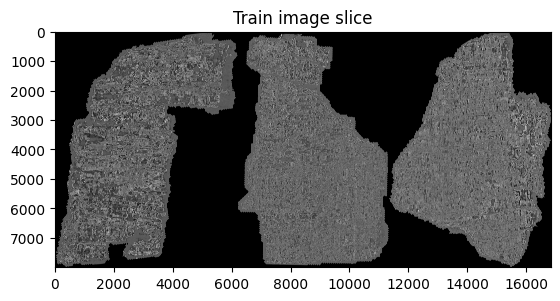

In [ ]:
print(f'Image shape {images_tensors.shape}')
fig, ax = plt.subplots()
ax.set_title('Train image slice')
ax.imshow(images_tensors[2], cmap='gray') #.cpu())
plt.show()

Label shape torch.Size([8000, 16836])


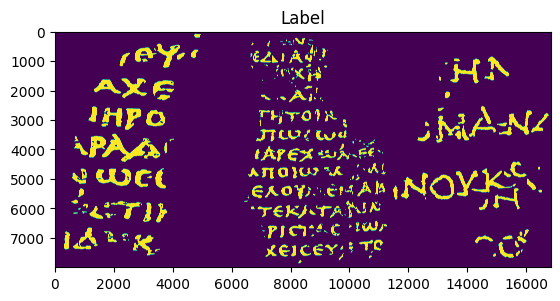

In [ ]:
print(f'Label shape {labels_tensors.shape}')
fig, ax = plt.subplots()
ax.set_title('Label')
ax.imshow(labels_tensors) #.cpu())
plt.show()

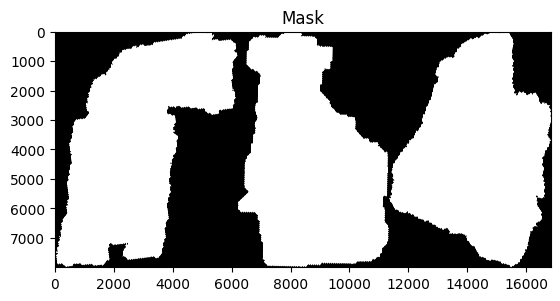

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Mask')
ax.imshow(masks_tensors, cmap='gray')
plt.show()

In [ ]:
buffer=15
validation_rectangle = (1100, 3500, 700, 950)
rectangle = validation_rectangle 
not_border = np.zeros(masks_tensors.shape, dtype=bool)
not_border[buffer: masks_tensors.shape[0] - buffer, buffer: masks_tensors.shape[1] - buffer]  = True 
array_mask = np.array(masks_tensors) * not_border
inside_rectangle = np.zeros(masks_tensors.shape, dtype=bool) * array_mask 
inside_rectangle[rectangle[1]:rectangle[1] + rectangle[3] +1, rectangle[0]:rectangle[0] + rectangle[2] +1] = True 
outside_rectangle = np.ones(masks_tensors.shape, dtype=bool) * array_mask 
outside_rectangle[rectangle[1]:rectangle[1] + rectangle[3] + 1, rectangle[0]:rectangle[0] + rectangle[2] + 1] = False 
pixels_inside_rectangle = np.argwhere(inside_rectangle)
pixels_outside_rectangle = np.argwhere(outside_rectangle)
del not_border ; del array_mask ; del inside_rectangle ; 
del outside_rectangle ; del pixels_outside_rectangle

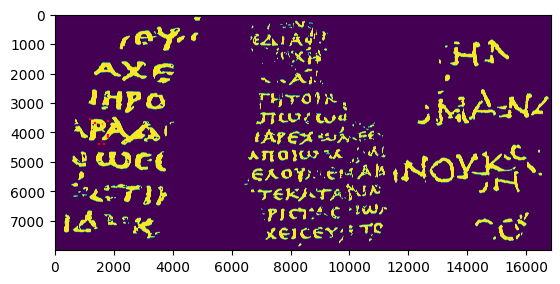

In [ ]:
buffer = 15
fig, ax = plt.subplots()
ax.imshow(labels_tensors) #.cpu())
for i in range(10):
  patches_number = np.random.randint(
      1, len(pixels_inside_rectangle))
  x, y = pixels_inside_rectangle[patches_number] 
  patch = patches.Rectangle([y - buffer, x - buffer], 2*buffer, 2*buffer,
                            edgecolor='r', facecolor='None')
  ax.add_patch(patch)
plt.show()

### Data Processing with NumPy

In [ ]:
def resize(image): 
  width, height = image.size
  aspect_ratio = width/height 
  shared_height = 8000
  new_width = int(shared_height * aspect_ratio)
  new_size = (new_width, shared_height)
  image = image.resize(new_size)
  return image

In [ ]:
z_slices, labels, masks = [[] for _ in range(3)], [[] for _ in range(3)], [[] for _ in range(3)]
for i in [1, 2, 3]:
  z_slices[i-1] += sorted(glob.glob(
      f'{PATHTRAIN}/train/{i}/surface_volume/*.tif'))[1:11]
  img_l = Image.open(f'{PATHTRAIN}train/{i}/inklabels.png')
  img_l = resize(img_l)
  labels[i -1]= torch.from_numpy(np.array(img_l)).gt(0).float()
  img_m = Image.open(f'{PATHTRAIN}train/{i}/mask.png').convert('1')
  img_m = resize(img_m)
  masks[i -1] = np.array(img_m)

z_slices
labels, 
len(z_slices)

In [ ]:
images = [[] for _ in range(3)]
for i in range(3):
  images_ = []
  for index_, filename in tqdm(enumerate(z_slices[i])):
    img_ = Image.open(filename)
    img_ = resize(img_)
    z_slice = np.array(img_, dtype='float32')/65535.0
    images_.append(z_slice)
  images[i] = torch.stack([torch.from_numpy(image) for image in images_], dim=0)


In [ ]:
images[0].shape, images[1].shape, images[2].shape,

In [ ]:
images_tensors = torch.cat([image for image in images], axis=-1)
labels_tensors = torch.cat([label for label in labels], axis=1)
masks_tensors = np.concatenate([mask for mask in masks], axis=-1)

In [ ]:
images_tensors.shape, labels_tensors.shape, masks_tensors.shape

In [ ]:
z_slices__ = [[] for _ in range(3)] 
z_labels__ = [[] for _ in range(3)] 
z_mask__   = [[] for _ in range(3)]  

In [ ]:
for i in [1, 2, 3]: 
  z_slices__[i -1]= sorted(glob.glob(f'{PATHTRAIN}train/{i}/surface_volume/*.tif'))
z_slices__[1]


In [ ]:
np.array(Image.open('/content/drive/MyDrive/A_Vesuvius/train/2/surface_volume/09.tif'), 
         dtype=np.float32)/65536.0 

In [ ]:
image_tensors__ = [np.array(Image.open(img_name), dtype=np.float32)/65536.0  
  for img_name in z_slices__[0] ] 

In [ ]:
image_stack = torch.stack([torch.from_numpy(image_tensor) 
for image_tensor in image_tensors__]) 
z_dimension = image_stack.shape[0]
image_stack.shape